In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.utils import plot_model

In [2]:
# Load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.round(x_train.astype('float32') / 255.)
x_test  = np.round(x_test.astype('float32')  / 255.)

x_train = x_train.reshape((x_train.shape[0], -1))
x_test  = x_test.reshape((x_test.shape[0], -1))

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


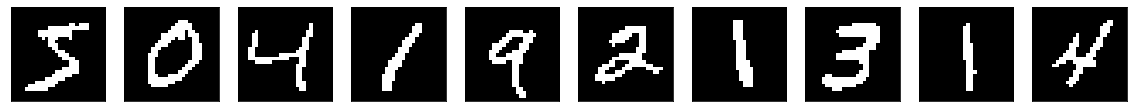

In [3]:
# Show a few examples
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [6]:
# Hyper-parameters
batch_size = 50
latent_len = 32

In [7]:
# AUX function -- Sampler
def sample_z(args):
    mean, var = args
    batch_size = tf.shape(mean)[0]
    eps = tf.random.normal(shape=(batch_size, latent_len))
    return mean + tf.exp(var) * eps

In [8]:
# Q(z|x) -- Define encoder
in_layer = Input(shape=(784,), name='INPUT')
h_q = Dense(512, activation='relu', name='H_Q')(in_layer)

mu = Dense(latent_len, activation='linear', name='MU')(h_q)
log_sigma = Dense(latent_len, activation='linear', name='SIGMA')(h_q)

In [9]:
# z ~ Q(z|X) -- Latent sample
z = Lambda(sample_z, name='Z')([mu, log_sigma])

In [65]:
# final encoder
encoder = Model(in_layer, z, name='ENCODER')
encoder.summary()

Model: "ENCODER"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
INPUT (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
H_Q (Dense)                     (None, 512)          401920      INPUT[0][0]                      
__________________________________________________________________________________________________
MU (Dense)                      (None, 32)           16416       H_Q[0][0]                        
__________________________________________________________________________________________________
SIGMA (Dense)                   (None, 32)           16416       H_Q[0][0]                        
____________________________________________________________________________________________

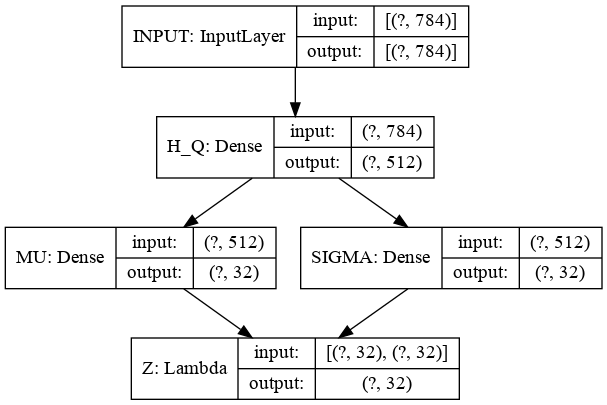

In [66]:
# Plot model
plot_model(encoder, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [67]:
# P(x|z) -- Define decoder
decode_in_layer = Input(shape=(latent_len,), name='IN_DECOD')
decode_hidden = Dense(512, activation='relu', name='H_P')(decode_in_layer)
decode_out_layer = Dense(784, activation='sigmoid', name='OUT')(decode_hidden)

decoder = Model(decode_in_layer, decode_out_layer, name='DECODER')
decoder.summary()

Model: "DECODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IN_DECOD (InputLayer)        [(None, 32)]              0         
_________________________________________________________________
H_P (Dense)                  (None, 512)               16896     
_________________________________________________________________
OUT (Dense)                  (None, 784)               402192    
Total params: 419,088
Trainable params: 419,088
Non-trainable params: 0
_________________________________________________________________


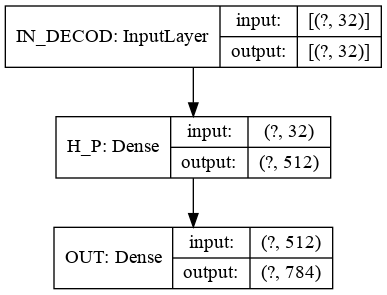

In [68]:
# Plot model
plot_model(decoder, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [69]:
# Create full Variational Autoencoder
out_layer = decoder(encoder(in_layer))
vae = Model(in_layer, out_layer, name='VAE')
vae.summary()

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
ENCODER (Model)              (None, 32)                434752    
_________________________________________________________________
DECODER (Model)              (None, 784)               419088    
Total params: 853,840
Trainable params: 853,840
Non-trainable params: 0
_________________________________________________________________


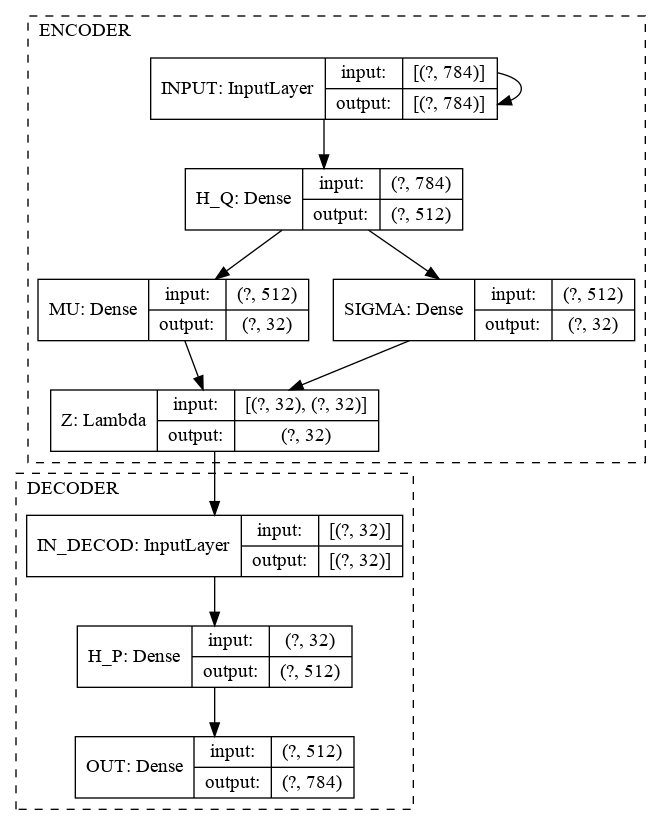

In [70]:
# Plot model
plot_model(vae, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [71]:
# AUX -- VAE custom loss (DKL + BCE)
def vae_loss(x, x_hat):
    # E[log P(X|z)] - BCE
    reconst = binary_crossentropy(tf.keras.backend.flatten(x), tf.keras.backend.flatten(x_hat))
    # D_KL(Q(z|X) || P(z|X))
    dkl = -0.5 * tf.reduce_sum(1 + log_sigma - tf.square(mu) - tf.exp(log_sigma), axis=-1)
    return reconst + 0.00003 * dkl

In [72]:
# Compile and train
vae.compile(optimizer='adam', loss=vae_loss, experimental_run_tf_function=False)
history = vae.fit(x_train, x_train, epochs=50, batch_size=batch_size, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 17s 363us/sample - loss: 0.0851 - val_loss: 0.0583
Epoch 2/50
48000/48000 [==============================] - 18s 378us/sample - loss: 0.0531 - val_loss: 0.0520
Epoch 3/50
48000/48000 [==============================] - 21s 432us/sample - loss: 0.0480 - val_loss: 0.0483
Epoch 4/50
48000/48000 [==============================] - 20s 415us/sample - loss: 0.0448 - val_loss: 0.0469
Epoch 5/50
48000/48000 [==============================] - 21s 440us/sample - loss: 0.0426 - val_loss: 0.0450
Epoch 6/50
48000/48000 [==============================] - 21s 429us/sample - loss: 0.0410 - val_loss: 0.0444
Epoch 7/50
48000/48000 [==============================] - 21s 439us/sample - loss: 0.0396 - val_loss: 0.0438
Epoch 8/50
48000/48000 [==============================] - 22s 458us/sample - loss: 0.0385 - val_loss: 0.0431
Epoch 9/50
48000/48000 [==============================] - 22s 455us/sample - l

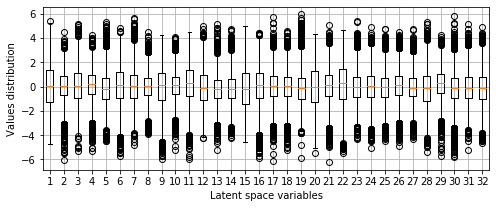

In [83]:
# Plot distribution of latent space
x_test_encoded = encoder.predict(x_test, batch_size=100)

plt.figure(figsize=(8, 3))
plt.boxplot(x_test_encoded)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()
plt.show()

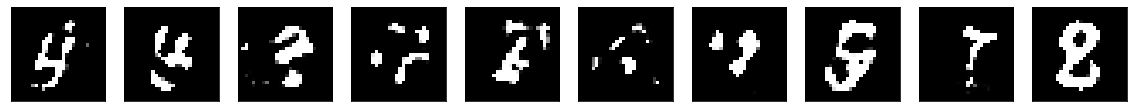

In [84]:
z_samples = np.random.normal(loc=0.0, scale=4., size=(10, latent_len))
x_hat_samples = decoder.predict(z_samples)

# Show a few reconstruction from random samples
plt.figure(figsize=(20, 3))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(x_hat_samples[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
n = 20  # figure with 15x15 digits -- NO
digit_size = 28

z1 = np.linspace(-3.99, 3.99, n)
z2 = np.linspace(-3.99, 3.99, n)
z_grid = np.dstack(np.meshgrid(z1, z2))
print(z_grid.shape)

x_pred_grid = decoder.predict(z_grid.reshape(n*n, latent_len)) \
                     .reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# Regular AE

In [48]:
# Define encoder
i = Input(shape=(784,))
h = Dense(512, activation='relu')(i)
l = Dense(32, activation='relu')(h)

enc = Model(i, l)
enc.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_17 (Dense)             (None, 32)                16416     
Total params: 418,336
Trainable params: 418,336
Non-trainable params: 0
_________________________________________________________________


In [49]:
# Define decoder
i_d = Input(shape=(32,))
h_d = Dense(512, activation='relu')(i_d)
o_d = Dense(784, activation='sigmoid')(h_d)

dec = Model(i_d, o_d)
dec.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               16896     
_________________________________________________________________
dense_19 (Dense)             (None, 784)               402192    
Total params: 419,088
Trainable params: 419,088
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Define full AE
o = dec(enc(i))
ae = Model(i, o)
ae.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
model_11 (Model)             (None, 32)                418336    
_________________________________________________________________
model_12 (Model)             (None, 784)               419088    
Total params: 837,424
Trainable params: 837,424
Non-trainable params: 0
_________________________________________________________________


In [51]:
# Compile and train
ae.compile(optimizer='adam', loss='bce')
history2 = ae.fit(x_train, x_train, epochs=50, batch_size=batch_size, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 15s 303us/sample - loss: 0.1176 - val_loss: 0.0769
Epoch 2/50
48000/48000 [==============================] - 16s 344us/sample - loss: 0.0691 - val_loss: 0.0653
Epoch 3/50
48000/48000 [==============================] - 17s 353us/sample - loss: 0.0608 - val_loss: 0.0597
Epoch 4/50
48000/48000 [==============================] - 18s 379us/sample - loss: 0.0559 - val_loss: 0.0564
Epoch 5/50
48000/48000 [==============================] - 18s 384us/sample - loss: 0.0527 - val_loss: 0.0540
Epoch 6/50
48000/48000 [==============================] - 18s 376us/sample - loss: 0.0505 - val_loss: 0.0532
Epoch 7/50
48000/48000 [==============================] - 20s 407us/sample - loss: 0.0486 - val_loss: 0.0516
Epoch 8/50
48000/48000 [==============================] - 20s 409us/sample - loss: 0.0473 - val_loss: 0.0510
Epoch 9/50
48000/48000 [==============================] - 21s 430us/sample - l

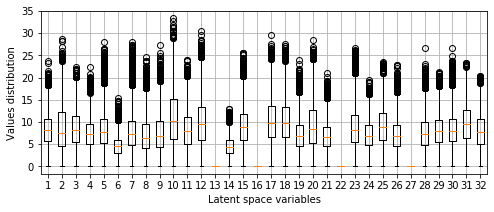

In [53]:
# Plot distribution of latent space
encoded2 = enc.predict(x_test, batch_size=100)
mean2 = encoded2.mean(axis=0)
std2  = encoded2.std(axis=0)

plt.figure(figsize=(8, 3))
plt.boxplot(encoded2)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()
plt.show()

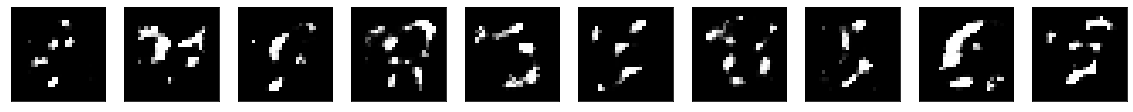

In [64]:
z_samples = np.random.normal(loc=0.0, scale=3., size=(10, latent_len))
x_hat_samples = dec.predict(z_samples)

# Show a few reconstruction from random samples
plt.figure(figsize=(20, 3))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(x_hat_samples[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# 2D Plots of 2D latent spaces

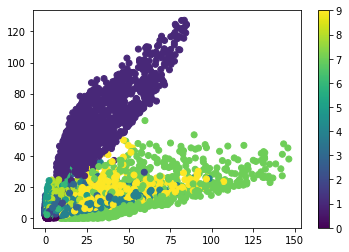

In [47]:
# Plot latent space for 2-D from "regular AE"

plt.scatter(encoded2[:, 0], encoded2[:, 1], c=y_test)
plt.colorbar()
plt.show()

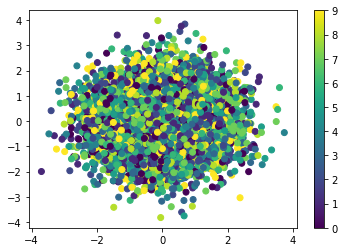

In [16]:
# Plot latent space for 2-D from "VAE"
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()